# Plotting FESOM data on HEALPix grid 
Initial code by Boris Shapkin, further modified by Bimo Niraula


In [1]:
import healpy as hp
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cf
import eccodes as ec
import ecmwflibs


In [2]:
# !pip install ecmwflibs
# In case eccodes is not working, try to install/upgrade ecmwflibs. Imp for the new DestiE Variables

In [3]:
# Are we using Nested Healpix or Ring? 
Nested=True

In [4]:
# Not used here, but can be useful elsewhere

def create_healpix_grid(longitudes,latitudes, nside):
    """
    Creates a Healpix grid from a set of latitude and longitude coordinates.

    Parameters:
        latitudes (array-like): Array of latitudes in radians.
        longitudes (array-like): Array of longitudes in radians.
        nside (int): The parameter that controls the resolution of the grid.

    Returns:
        healpix_pixels (array): Array representing the Healpix grid.
    """
    healpix_pixels = hp.ang2pix(nside,longitudes, latitudes, lonlat = True)
    return healpix_pixels

## Plotting functions


In [5]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    Plots a variable on a Healpix.

    Args:
        var (array-like): Variable on Healpix coordinates (e.g., numpy array).
        nx (int, optional): Image resolution in the x-direction (default is 1000).
        ny (int, optional): Image resolution in the y-direction (default is 1000).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If not provided,
            the current axis will be used (default is None).
        **kwargs: Additional arguments to pass to the imshow function.
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=Nested, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)

In [6]:
def worldmap(var,cbar,clabel = None,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(14, 7), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        if clabel == None: # Set the label for the colorbar
            cbar.set_label(" ")
        else:
            cbar.set_label(clabel)  

In [7]:
def plot_healpix(data_healpix,
                 proj = 'mercator',
                 extent = None,
                 interactive = False,
                 cmap=cm.Spectral_r,
                 cbar = False,
                 clabel = None,
                 vmin = None,vmax = None,
                 savefig = False,
                savepath = None,
                closefile=False):
    
    """
    Plots data on a Healpix grid with various customization options.

    The function takes data defined on a Healpix grid and visualizes it on a specified
    map projection. 
    Args:
        data_healpix (array-like): Data on a Healpix grid.
        proj (str, optional): The map projection to use. Supported options are 'mercator',
            'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
            Default is 'mercator'.
        extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
            min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
        interactive (bool, optional): If True, the plot is displayed interactively with
            widgets for zooming and panning. If False, a static image is displayed.
            Default is False.
        cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
        cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
            Default is False.
        vmin (float, optional): The lower limit for the color scale. If not provided, the
            minimum value in 'data_healpix' will be used.
        vmax (float, optional): The upper limit for the color scale. If not provided, the
            maximum value in 'data_healpix' will be used.
        savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
            is not saved. Default is False.
        savepath (str, optional): The path to save the image file. Default is None, which
            saves the image in the current working directory.
    """
    if (savefig == True) and (os.path.exists(savepath)):
        return
    if vmin is None:
        vmin = np.nanmin(data_healpix)
    if vmax is None:
        vmax = np.nanmax(data_healpix)
    if interactive == False:
        %matplotlib inline

        if extent == None:
            worldmap(data_healpix, cbar,clabel=clabel,cmap=cmap,vmin = vmin, vmax = vmax)
        else:
            if proj == 'mercator':
                projection = ccrs.Mercator(central_longitude=0)
            elif proj == 'np':
                projection = ccrs.NorthPolarStereo(central_longitude=0)
            elif proj == 'sp':
                 projection = ccrs.SouthPolarStereo(central_longitude=0)
            fig, ax = plt.subplots(
                figsize=(14, 10), subplot_kw={"projection": projection}, constrained_layout=True
            )
            ax.set_extent(extent, ccrs.PlateCarree())
            nnshow(data_healpix, ax=ax, cmap=cmap,vmin = vmin, vmax = vmax)
            ax.add_feature(cf.COASTLINE, linewidth=0.8)
            
            # Add a colorbar to the plot
            if cbar is not False:
                cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
                if clabel== None: # Set the label for the colorbar
                    cbar.set_label(" ")
                else:
                    cbar.set_label(clabel)  
    else:
        %matplotlib widget
        hp.mollzoom(data_healpix,
                    flip="geo",
                    cmap =cmap,
                    min = vmin, max = vmax,
                    title=clabel,nest=Nested)
    if savefig == True:
        plt.savefig(savepath,dpi = 500, format = 'jpg')
    plt.show()
    if closefile == True:
        plt.close()

In [8]:
## Extracting data 
# Easiest way is to use eccodes, find the first grib code and use ec.codes_get. 
# If a file has more than one message/level/variable, then it might be necessary to loop through them.
# One can also use pygrib or possibly xarray but have not tried so far.

native_data_file ="/work/ab0995/a270138/Data/GRIB/HPix_testedOutputs/high:fc:o2d.20240211.173832.l40695.lvt.dkrz.de.852194525970476.data"
fin = open(native_data_file, 'rb')
gid = ec.codes_grib_new_from_file(fin)
varname=(ec.codes_get(gid,"shortName"))
date=(ec.codes_get(gid,"date"))
data_healpix=ec.codes_get_values(gid)
print('Extracted',varname,'for ',date )
fin.close()

#Land cells default to high values, so we can filter them out
dataOG=data_healpix
data_healpix[data_healpix>1000]=np.nan

print("Healpix data size: ",len(data_healpix))

Extracted avg_tos for  20200122
Healpix data size:  3145728


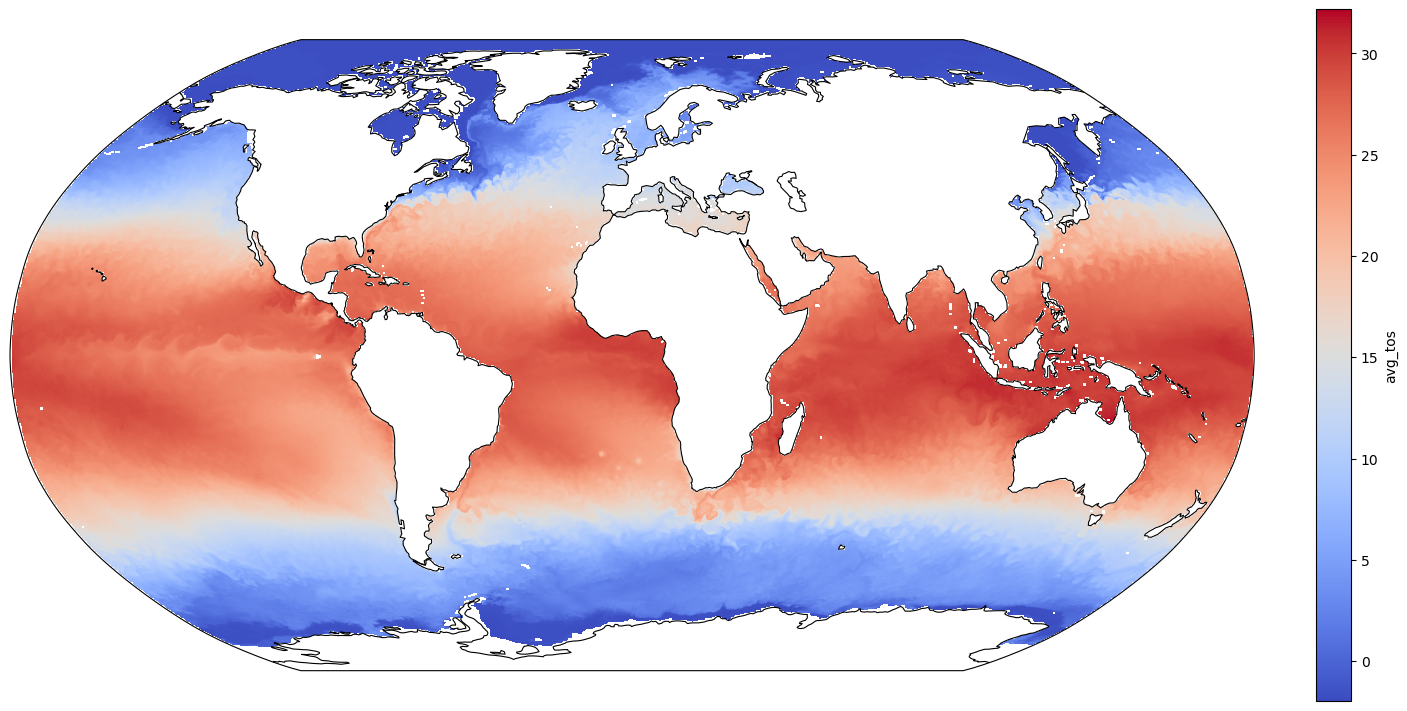

In [9]:
#Then plotting!

fname='/work/ab0995/a270138/Data/GRIB/Figures/Tco1279_Healpix_SuviRun_'+varname+'_for_'+str(date)+'.jpeg'
plot_healpix(data_healpix,cbar=True,clabel= varname,cmap='coolwarm',savefig=False,savepath=fname)#, vmin=-2, vmax=33)
#Figure is not saved here but use fname to give proper path and change savefig==True to save

Extracted avg_siconc for  20200122


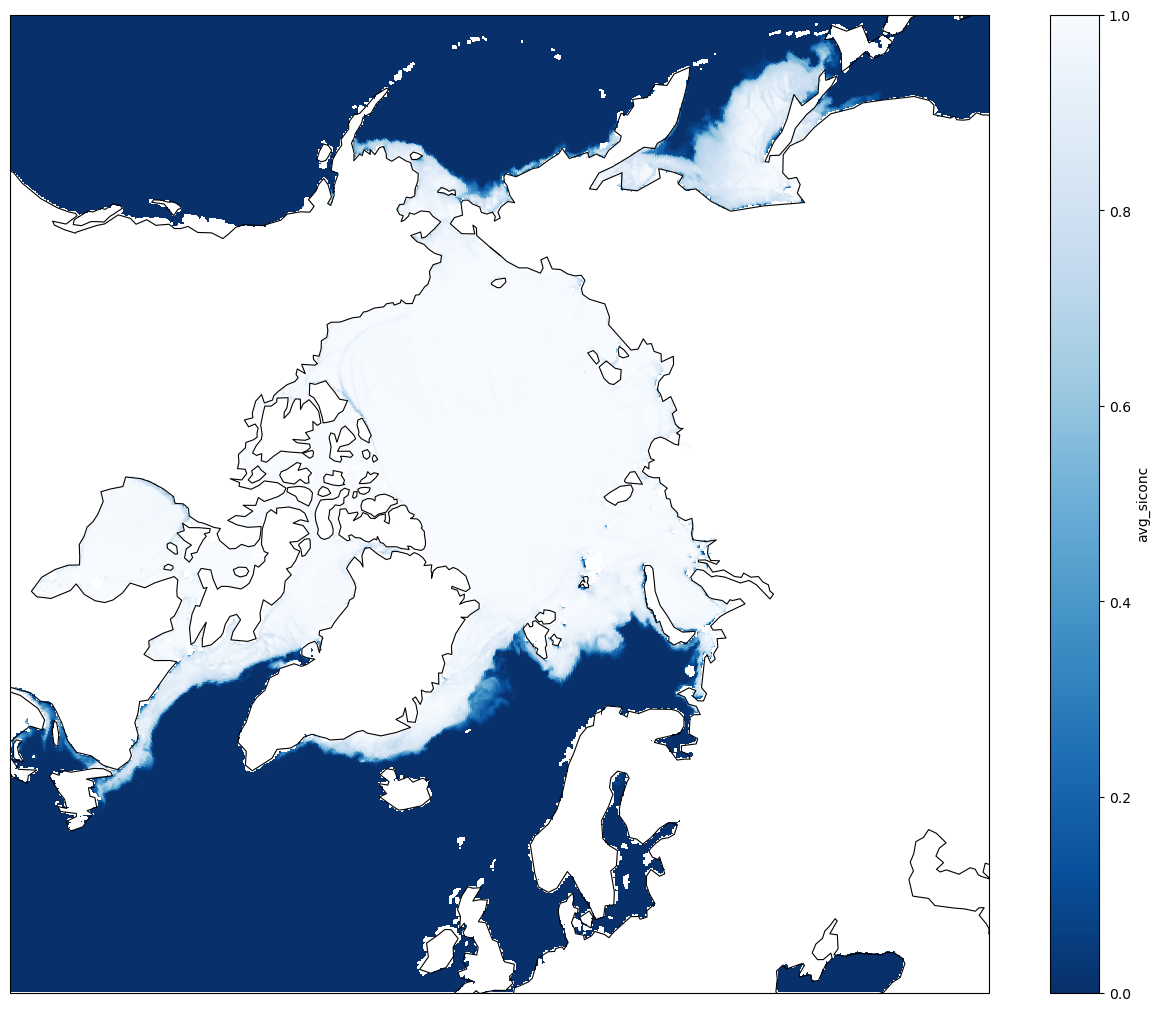

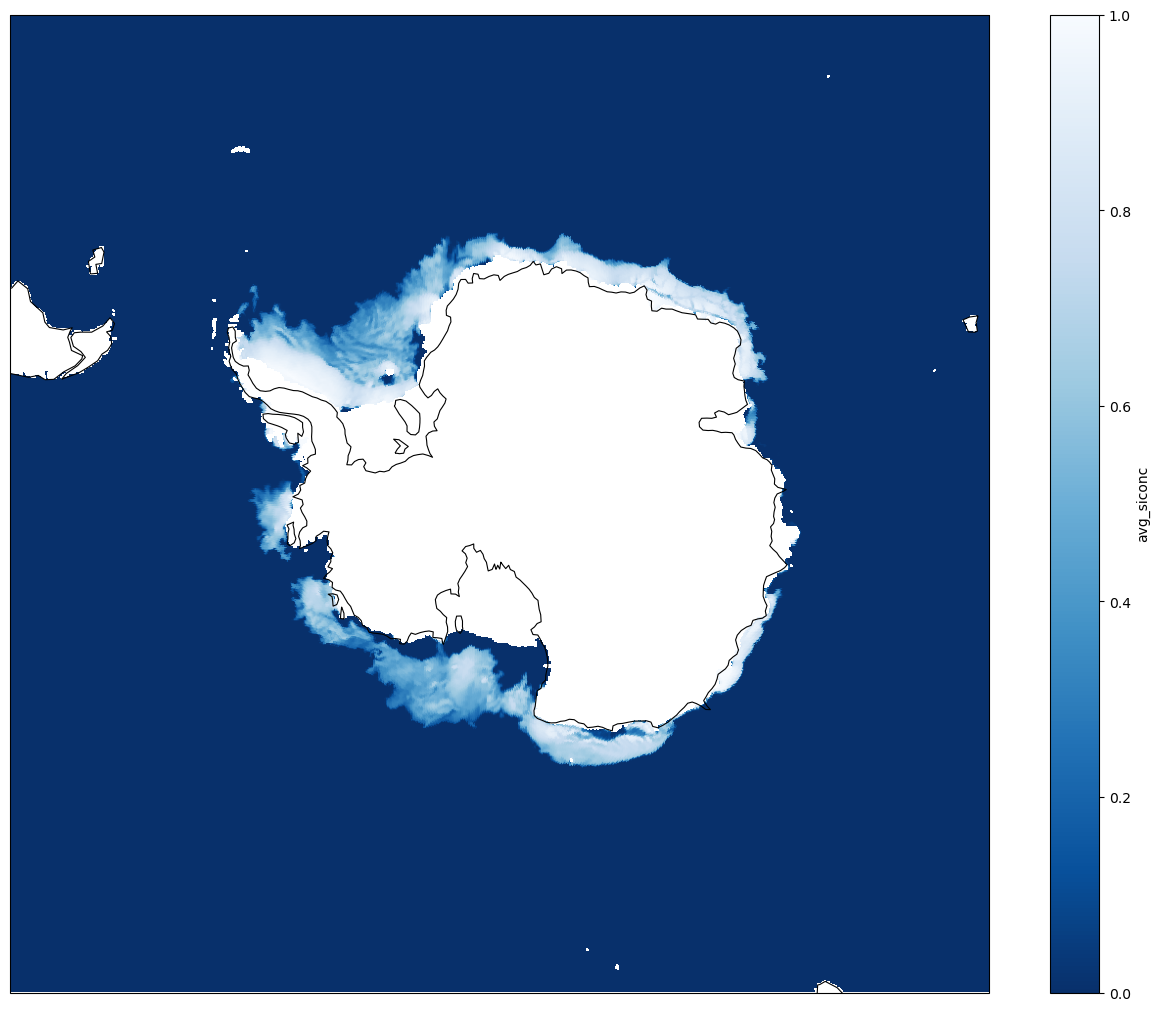

In [10]:
## Similarly we can make easy polar-stereo plots:

native_data_file ="/work/ab0995/a270138/Data/GRIB/HPix_testedOutputs/high:fc:o2d.20240211.173831.l40695.lvt.dkrz.de.852181641068588.data"
fin = open(native_data_file, 'rb')
gid = ec.codes_grib_new_from_file(fin)
varname=(ec.codes_get(gid,"shortName"))
date=(ec.codes_get(gid,"date"))
data_healpix=ec.codes_get_values(gid)
print('Extracted',varname,'for ',date )
fin.close()

#Land cells default to high values, so we can filter them out
dataOG=data_healpix
data_healpix[data_healpix>1000]=np.nan
fname='/work/ab0995/a270138/Data/GRIB/Figures/Tco1279_Healpix_SuviRun_NorthPole_'+varname+'_for_'+str(date)+'.jpeg'
plot_healpix(data_healpix, extent = [-180,180,50,90], proj = 'np', cbar = True,clabel= varname,cmap='Blues_r', savefig=False,savepath=fname)

fname='/work/ab0995/a270138/Data/GRIB/Figures/Tco1279_Healpix_SuviRun_NorthPole_'+varname+'_for_'+str(date)+'.jpeg'
plot_healpix(data_healpix, extent = [-180,180,-50,-90], proj = 'sp', cbar = True,clabel= varname,cmap='Blues_r', savefig=False,savepath=fname)


In [ ]:
# Plotting all of AMIP runs:
# Some folders caused error, so writing a catch on those


import glob
import os
# Directory containing the files
Path1 = "/work/bm1235/b382776/cycle4/fdb/healpix/root/"
Figpath="/work/ab0995/a270138/Data/GRIB/Figures/ThomasRuns/HealpixSTD/tco1279_HealpixSTD"


for subdir in os.listdir(Path1):
    subdir_path = os.path.join(Path1, subdir)
    # Check if the item in Path1 is a directory
    if not os.path.isdir(subdir_path):
        print("Not dir: ",subdir_path)
        continue
    file_list = glob.glob(os.path.join(subdir_path, "sta*o2d*.data"))        

    # Loop over each file
    for file_path in file_list:
        try:
            # Process each file
            fin = open(file_path, 'rb')
            gid = ec.codes_grib_new_from_file(fin)
            varname=(ec.codes_get(gid,"shortName"))
            date=(ec.codes_get(gid,"date"))
            data_healpix=ec.codes_get_values(gid)
            print(varname,' data for ',date )
            fin.close()

            label="";colmap='vivid';vmin=np.nan; vmax=np.nan;shouldweplot=0
            if varname=="avg_tos":
                label="SST (°C)"
                colmap='coolwarm'
                vmin=-2; vmax=33
                shouldweplot=1
            if varname=="avg_sos":
                label="Sea Surface Salinity (psu)"
                #colmap='YlGnBu'
                colmap='terrain_r'
                vmin=3; vmax=41
                shouldweplot=1
            if varname=="avg_zos":
                label="Sea Surface Height (m)"
                colmap='YlGnBu_r'
                vmin=np.nan; vmax=np.nan
                shouldweplot=1

            dataOG=data_healpix
            data_healpix[data_healpix>1000]=np.nan

            if (varname=="avg_siconc") or (varname=="avg_sisnthick") or (varname=="avg_sithick"):
                fname=Figpath+'_NorthPole_'+varname+'_for_'+str(date)+'.jpeg'
                plot_healpix(data_healpix, extent = [-180,180,50,90], proj = 'np', cbar = True,clabel= varname,cmap='Blues_r', savefig=True,savepath=fname,closefile=True)

                fname=Figpath+'_SouthPole_'+varname+'_for_'+str(date)+'.jpeg'
                plot_healpix(data_healpix, extent = [-180,180,-50,-90], proj = 'sp', cbar = True,clabel= varname,cmap='Blues_r', savefig=True,savepath=fname,closefile=True)

            if (shouldweplot==1):           
                fname=Figpath+'_'+varname+'_for_'+str(date)+'.jpg'
                plot_healpix(data_healpix,cbar=True,clabel= label,cmap=colmap,savefig=True,savepath=fname, vmin=vmin, vmax=vmax)
      #          plt.close('all')
        except Exception as e:
            # Handle the exception gracefully
            print(f"An error occurred : {e}")
            print("In this file: ",file_path)
            # Optionally, continue to the next iteration of the loop
            continue